In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# The Iterative K-means -/+ algorithm  
As seen in Ismkahn (2018)  
Coded by Henry Morgan, ULB Data Science

Note: Ismkahn's original C++ code is available on his researchgate profile, but this code is independently generated and may differ in implementation strategies

In [54]:
import timeit
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Center and Point classes

### Center

In [41]:
class center:
# a class to capture the required attributes of a cluster for the algorithms
# Need: uniqueID
# Need: list of associated point indices
# Need: Center coordinates
# Need: indivisible marker
# Need: irremovable marker

    __slots__ = '_loc','_id','_irremovable','_indivisible','_points','_unmatchable'
  
    def __init__(self, coordinates, index):
    # initialisation requires an NP array holding the center's starting coordinates and the initialisation index of the center
        self._loc = coordinates
        self._id = index
        self._irremovable = False
        self._indivisible = False
        self._points = []
        self._unmatchable = []
    
    def getID(self):
        return self._id
    
    def addPoint(self,pt):
        self._points.append(pt)
    def countPoints(self):
        return len(self._points)
    def getPoints(self):
        return self._points
    def resetPoints(self):
        self._points = []
    
    def updateLoc(self,newCoords):
        self._loc = newCoords
    def getLoc(self):
        return self._loc    
    
    def setIndivisible(self):
        self._indivisible = True
    def getIndivisible(self):
        return self._indivisible
            
    def setIrremovable(self):
        self._irremovable = True
    def getIrremovable(self):
        return self._irremovable
    
    def setUnmatchable(self,otherCenterIndex):
        self._unmatchable.append(otherCenterIndex)
    def getUnmatchable(self):
        return self._unmatchable

### Point

In [24]:
class point:
# Class which captures the required attributes of a point for the algorithm
# Need: coordinates
# Need: First and Second closest centers
# Need: Distance to first and second closest centers
# Need: Useful Nearest Centers
    
    __slots__ = "_loc","_center","_disFirst","_secondCenter","_disSecond"
    
    def __init__(self, coordinates):
    # initialises point at coordinates X
    # receives coordinates as a Numpy Array
        self._loc = coordinates

    def getLoc(self):
        return self._loc
    
    def setFirstCenter(self,center):
        self._center = center
    def getCenter(self):
        return self._center
    def setFirstDistance(self,dis):
        self._disFirst = dis
    def disToFirst(self):
        return self._disFirst
    
    def setSecondCenter(self,center):
        self._secondCenter = center
    def getSecondCenter(self):
        return self._secondCenter
    def setSecondDistance(self,dis):
        self._disSecond = dis
    def disToSecond(self):
        return self._disSecond

## Useful Nearest Center initialisation algorithm

In [5]:
def distance(X1, X2):
# Function to calculate euclidean distance between two points or two centers
# Accepts two point or center class variables
# Returns the euclidean distance calculated as the norm of the difference of their coordinates

    return np.linalg.norm(X1.getLoc()-X2.getLoc())

In [32]:
def usefulCenters(pointCheck, centers):
# Calculates the useful nearest centers of a given point
# Receives a point class variable and a list of center class variables
# Returns a list of center class variables representing the useful nearest centers
# NOTE: INEFFICIENT CODE --> REVISIT

    UNClist = []
    
    # Loop through centers and identify useful centers for given point
    for i in range(len(centers)):
        disPC = distance(pointCheck, centers[i])
        useless = False
        
        # Loop through other centers to determine if center i is useless
        # NOTE: INEFFICIENT CODE
        for j in range(len(centers)):
            if i != j:
                disPCx = distance(pointCheck, centers[j])
                disCCx = distance(centers[i], centers[j])
                if disPCx < disPC and disCCx < disPC:
                    useless = True
                    
        if useless == False:
            UNClist.append(centers[i])
    
    return UNClist

In [33]:
def UNCinit(points, maxCenters):
# Initialises the K-Means center with the Useful Nearest Center algorithm
# Receives a list of point class variables and a maxumum number of centers
# Returns the list of initial center class variables

    centerList = []

    # Loop through points and identify point with lowest first dimension value to be the first center
    minDimension = points[0].getLoc()[0]
    startPoint = points[0]
    startPointIndex = 0
    for i in range(len(points)):
        firstDimension = points[i].getLoc()[0]
        if firstDimension < minDimension:
            minDimension = firstDimension
            startPoint = points[i]
            startPointIndex = i
            
    # Instantiate a center at the given location, and remove the point from the list of possible centers
    centerCount = 1
    centerList.append(center(startPoint.getLoc(),centerCount))
    del points[startPointIndex]
    
    # Now need to loop until maximum number of centers is achieved
    while len(centerList) < maxCenters:
        
        # Calculate next optimal center
        maxFormula = 0
        maxPoint = 0
        maxPointIndex = 0
        for i in range(len(points)):
            UNCi = usefulCenters(points[i], centerList)
            
            # Need to loop through useful nearest centers and calculate required distances to i
            maxDist = 0
            sumDist = 0
            sumLnDist = 0
            for j in UNCi:
                dist = distance(points[i],j)
                if dist > maxDist:
                    maxDist = dist
                sumDist += dist
                sumLnDist += np.log(dist)
            avgDist = sumDist/len(UNCi)
            
            # Calculate the formula of Ismkahn (2017) and compare to previous max
            formula = (avgDist/maxDist)*sumLnDist
            if formula > maxFormula:
                maxFormula = formula
                maxPoint = points[i]
                maxPointIndex = i

        # Instantiate a center at the given location, and remove the point from the list
        centerCount += 1
        centerList.append(center(maxPoint.getLoc(), centerCount))
        del points[maxPointIndex]
        
    return centerList

## SSEDM, Gain/Cost, & Adjacency functions

### SSEDM

In [45]:
def SSEDMi(center):
# Function to calculate the sum of squared euclidean distances from the mean (center) of the given cluster
# Function receives a center class object
# Function returns the calculated SSEDM for that center

    points = center.getPoints()
    SSEDMi = 0
    
    # Loop through the cluster's points to calculate their distances to the mean
    # NEED INDEX OF ALL POINTS
    for i in points:
        SSEDMi += distance(i, center) ** 2
    
    return SSEDMi

def SSEDM(centerList):
# Function to calculate the sum of squared euclidean distances from the mean (center) of all clusters
# Function receives a list of center class objects
# Function returns the sum of calculated SSEDM for every cluster

    SSEDM = 0
    
    for i in centerList:
        SSEDM += SSEDMi(i)
    
    return SSEDM

### Cost calculation
the approximated cost of removing the cluster Sj is the increase in the total SSEDM over all clusters, SSEDM(S), after Sj is removed

In [9]:
def cost(removalCenter):
# Function to approximate the cost of removing the center from the overall solution
# Receives a center class object
# Returns the approximated cost of the removal

    sumSecondCenter = 0
    for i in removalCenter.getPoints():
        sumSecondCenter += i.disToSecond()**2
    
    return SSEDMi(removalCenter) - sumSecondCenter

### Gain calculation

In [10]:
def gain(splitCenter, alpha = 3/4):
# Function to approximate the gain of splitting one cluster into two clusters
# Receives a center class object, an alpha value which defaults to 3/4
# Returns the approximated gain for the split

    return alpha * SSEDMi(splitCenter)

### Adjacency

In [49]:
def adjacent(centerI, centerJ, centerList):
# Function to determine if two centers are adjacent according to Ismkahn's definition
# Receives two center class objects
# Returns True if centerJ is adjacent to centerI
# Returns False otherwise

    for i in centerI.getPoints():
        if centerList[i.getSecondCenter()].getID() == centerJ.getID():
            return True
    
    return False

def strongAdjacent(centerI, centerJ, centerList):
# Function to determine if two centers are strongly adjacent according to Ismkahn's definition
# Receives two center class objects
# Returns True if centerJ is strongly adjacent to centerI
# Returns False otherwise

    if adjacent(centerI, centerJ, centerList) == True and adjacent(centerJ, centerI, centerList) == True:
        return True
    
    return False

def getAdjacentCenters(centerList, centerIndex):
# Generates a list of all centers in centerList which are adjacent to center at centerIndex
# Receives a list of center class objects and one index to be checked against
# Returns a list of indexes where centers are adjacent to the center at centerIndex
    
    adj = []
    for i in range(len(centerList)):
        if i != centerIndex:
            if adjacent(centerList[centerIndex], centerList[i], centerList) == True:
                adj.append(i)
    
    return adj

### Affected points  
Definition: in solution S, point P is an affected point of center Ci iff the first or second nearest center of P is Ci

In [12]:
def affectedPointsInit(point, center):
# Determines if point is an affected point of center
# For the special T-K-means iteration 1 case, where we have not yet updated global point attributes
# Active center list contains the split Si - all affected points of pre-split Si will still be affected

# Receives point and center class objects and a list of all centers
# Returns True if the point is affected
# Returns False otherwise
    
    second = point.disToSecond()
    new = distance(point, center)
    if new < second:
        return True
    
def affectedPoints(point, center, centerList):
# Determines if point is an affected point of center
# Receives point and center class objects and a list of all centers
# Returns True if the point is affected
# Returns False otherwise
    
    if centerList[point.getCenter()].getID() == center.getID() or centerList[point.getSecondCenter()].getID() == center.getID():
        return True
    
    return False

## Topical K-means algorithm  
As applied to a set where the center Cj of cluster Sj is changed to be a random point in Si which has center Ci (i.e. Sj has been deleted and Si has been split)

In [154]:
def TKmeans(allCenters, allPoints, deletedIndex, splitIndex):
 
    dimension = allPoints[0].getLoc().shape[0]
    
    # Define active centers as a set holding the new centers formed by splitting(here same as splitIndex & deletedIndex)
    AC = {splitIndex, deletedIndex}
    
    # Add adjacent center indices of the deleted and split center to list (including the split center here due to construction of getAdjacentCenters())
    ACAdj = set()
    ACAdj.update(getAdjacentCenters(allCenters, deletedIndex))
    ACAdj.update(getAdjacentCenters(allCenters, splitIndex))
    
    # Add affected point indices of the deleted center to set
    AP = set()
    for i in range(len(allPoints)):
        if affectedPoints(allPoints[i], allCenters[deletedIndex], allCenters) == True:
            AP.add(i)

    # Update the coordinates of the deleted center to match a random point in the split center
    allCenters[deletedIndex].updateLoc(random.choice(allCenters[splitIndex].getPoints()).getLoc())
    
    # Simple counter for loop
    loop = 1
    
    # Once there are no more active centers, end the algorithm
    while len(AC)!= 0:
        
        # Create a list of centers adjacent to those in AC
        # Note - this has already been done in the first loop
        if loop != 1:
            ACAdj = set()
            for i in AC:
                ACAdj.update(getAdjacentCenters(allCenters, i))
        
        # Create a (now empty) set of potential Active Center indices
        PAC = set()
        
        # Add the affected point indices of centers in AC to list
        if loop == 1:
            # if we are in the first loop, we have the affected points of the old deleted center already
            # we only need to add the others
            # COULD PROBABLY REMOVE SOME LOOPING HERE BY HAVING IT CHECK AGAINST A LIST
            for i in range(len(allPoints)):
                for j in AC:
                    # Use affectedPointsInit, which will compare distances and not stored attributes
                    if affectedPointsInit(allPoints[i], allCenters[j]) == True:
                        AP.add(i)       
        else:
            AP = set()
            for i in range(len(allPoints)):
                for j in AC:
                    if affectedPoints(allPoints[i], allCenters[j], allCenters) == True:
                        AP.add(i)

        updateCenters = AC
        updateCenters.update(ACAdj)
        changed = False
        for i in AP:
            minDist = ()
            secondMin = ()

            for j in updateCenters:
                dist = distance(allPoints[i], allCenters[j])
                if len(minDist) == 0:
                    minDist = (dist,j)
                elif dist < minDist[0]:
                    secondMin = minDist
                    minDist = (dist,j)
                elif len(secondMin) == 0:
                    secondMin = (dist,j)
                elif dist < secondMin[0]:
                    secondMin = (dist,j)
            
            if minDist[1] != allPoints[i].getCenter():
                changed = True
                PAC.add(allPoints[i].getCenter())
                PAC.add(minDist[1])

            allPoints[i].setFirstCenter(minDist[1])
            allPoints[i].setFirstDistance(minDist[0])
            allPoints[i].setSecondCenter(secondMin[1])
            allPoints[i].setSecondDistance(secondMin[0])
            allCenters[minDist[1]].addPoint(allPoints[i])
        
        if changed == True:
            for i in updateCenters:
                pointLocs = np.zeros((allCenters[i].countPoints(),dimension))
                updatePoints = allCenters[i].getPoints()
                for j in range(allCenters[i].countPoints()):
                    pointLocs[j] = updatePoints[j].getLoc()
                allCenters[i].updateLoc(np.mean(pointLocs, axis=0))
                allCenters[i].resetPoints()
        
        AC = PAC
        loop += 1
    
    return allCenters, allPoints

## Iterative K-means -/+ algorithm

In [149]:
def unmatchable(centerList, index1, index2):
# receives a list of centers and two indexes
# returns True if the centers at both indexes are unmatchable
# returns False otherwise

    for i in centerList[index1].getUnmatchable():
        if i == index2:
            return True
    return False

In [150]:
def IKMeans(allPoints, centerCount):
# Runs the Iterative K Means -+ algorithm
# Receives an initial list of allPoints and a number of centers to create
# Returns centers

    dimension = allPoints[0].getLoc().shape[0]
    
    allCenters = UNCinit(allPoints, centerCount)
        
    # Assign allPoints and iterate to a solution set of centers and allPoints
    changed = True
    while changed == True:
        changed = False
        
        for i in allPoints:
            minDist = ()
            secondMin = ()

            for j in range(len(allCenters)):
                dist = distance(i, allCenters[j])
                if len(minDist) == 0:
                    minDist = (dist,j)
                elif dist < minDist[0]:
                    secondMin = (minDist[0],minDist[1])
                    minDist = (dist,j)
                elif len(secondMin) == 0:
                    secondMin = (dist,j)
                elif dist < secondMin[0]:
                    secondMin = (dist,j)
            
            try:
                if minDist[1] != i.getCenter():
                    changed = True
            except:
                pass

            i.setFirstCenter(minDist[1])
            i.setFirstDistance(minDist[0])
            i.setSecondCenter(secondMin[1])
            i.setSecondDistance(secondMin[0])
            allCenters[minDist[1]].addPoint(i)
        
        if changed == True:
            for i in range(len(allCenters)):
                pointLocs = np.zeros((allCenters[i].countPoints(),dimension))
                updatePoints = allCenters[i].getPoints()
                for j in range(allCenters[i].countPoints()):
                    pointLocs[j] = updatePoints[j].getLoc()
                allCenters[i].updateLoc(np.mean(pointLocs, axis=0))
                allCenters[i].resetPoints()
    
    success = 0
    
    while success <= centerCount/2:
    
        largestGain = ()
        for i in range(len(allCenters)):
            if allCenters[i].getIndivisible() == False:
                centerGain = gain(allCenters[i])
                if len(largestGain) == 0:
                    largestGain = (centerGain,i)
                elif centerGain > largestGain[0]:
                    largestGain = (centerGain,i)
        if len(largestGain) == 0:
            break
            
        clustersLarger = 0
        for i in range(len(allCenters)):
            if allCenters[i].getIndivisible() == True:
                if gain(allCenters[i]) > largestGain[0]:
                    clustersLarger += 1
        if clustersLarger >= centerCount/2:
            break
            
        lowestCost = ()
        for j in range(len(allCenters)):
            if j != largestGain[1]\
            and cost(allCenters[j]) < gain(allCenters[largestGain[1]]) \
            and unmatchable(allCenters, j, largestGain[1]) == False \
            and adjacent(allCenters[j],allCenters[largestGain[1]], allCenters) == False\
            and adjacent(allCenters[largestGain[1]],allCenters[j], allCenters) == False\
            and allCenters[j].getIrremovable() == False:
                centerCost = cost(allCenters[j])
                if len(lowestCost) == 0:
                    lowestCost = (centerCost,i)
                elif centerGain < lowestCost[0]:
                    lowestCost = (centerCost,i)
        if len(lowestCost) == 0:
            break
        
        clustersSmaller = 0
        for j in range(len(allCenters)):
            if j != largestGain[1]\
            and cost(allCenters[j]) < gain(allCenters[largestGain[1]]) \
            and unmatchable(allCenters, j, largestGain[1]) == False \
            and adjacent(allCenters[j],allCenters[largestGain[1]], allCenters) == False\
            and adjacent(allCenters[largestGain[1]],allCenters[j], allCenters) == False\
            and allCenters[j].getIrremovable() == True:
                if cost(allCenters[j]) < lowestCost[0]:
                    clustersSmaller += 1
        if clustersSmaller >= centerCount/2:
            break
       
        clustersSmaller = 0
        for j in range(len(allCenters)):
            if cost(allCenters[j]) < lowestCost[0]:
                    clustersSmaller += 1
        if clustersSmaller >= centerCount/2:
            allCenters[largestGain[1]].setIndivisible()
            continue
        
        newCenters = allCenters
        newPoints = allPoints
        newCenters, newPoints = TKmeans(newCenters, newPoints, lowestCost[1], largestGain[1])
        
        if SSEDM(newCenters) > SSEDM(allCenters):
            allCenters[lowestCost[1].setUnmatchable(largestGain[1])]
            allCenters[largestGain[1].setUnmatchable(lowestCost[1])]
            continue
        
        newCenters[lowestCost[1]].setIrremovable()
        newCenters[largestGain[1]].setIrremovable()
        
        for i in range(len(allCenters)):
            if i != lowestCost[1] and strongAdjacent(allCenters[lowestCost[1]], allCenters[i], allCenters) == True:
                newCenters[i].setIndivisible()
        
        allCenters = newCenters
        allPoints = newPoints
        
        for i in range(len(allCenters)):
            if i != lowestCost[1] and strongAdjacent(allCenters[lowestCost[1]], allCenters[i], allCenters) == True:
                newCenters[i].setIrremovable()
            if i != largestGain[1] and strongAdjacent(allCenters[largestGain[1]], allCenters[i], allCenters) == True:
                newCenters[i].setIrremovable()
        
        success += 1
        
    return allCenters, allPoints

## Trials

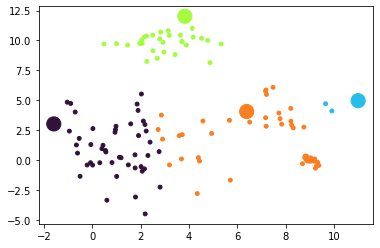

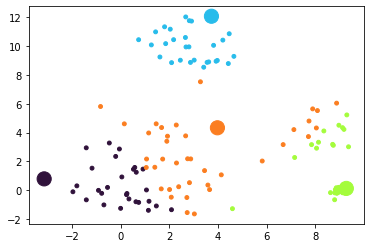

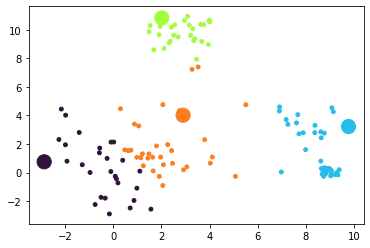

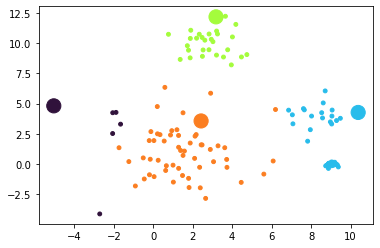

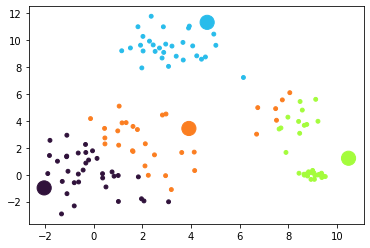

KeyboardInterrupt: 

In [156]:
def twodnormal(center,sigma,count):
# code of John Iacono
    return [ (point(np.array([random.normalvariate(center[0],sigma),
              random.normalvariate(center[1],sigma)]))) for i in range(count)]

def trythings():
    data=twodnormal( (8,4) ,1,20)+twodnormal( (1,1) ,2,60)+twodnormal( (3,10) ,1,30)+twodnormal( (9,0) ,0.2,20)

    centers, points = IKMeans(data,4)

    nx=[]
    ny=[]
    sizes=[]
    cols=[]
    cm=matplotlib.cm.get_cmap('turbo')
    for m,c in zip(centers,[cm(i/len(centers)) for i in range(len(centers))]):
        nx.append(m.getLoc()[0])
        ny.append(m.getLoc()[1])
        cols.append(c)
        sizes.append(200)
        for i in m.getPoints():
            loc = i.getLoc()
            nx.append(loc[0])
            ny.append(loc[1])
        cols.extend([c]*m.countPoints())
        sizes.extend([15]*m.countPoints())

    plt.plot(figsize=(20, 15))
    plt.scatter(nx, ny,sizes,cols) 
    plt.show()

for i in range(100):
    trythings()

In [131]:
# Code from H440 by John Iacono
    
def plotruntimes(functions,labels,r,data,trials=1,figsize=[3,3]):
# Function which will plot runtimes of a set of functions
# Takes:
    # A list of functions
    # Their labels(names), 
    # The defining parameter (in this case the number of clusters)
    # The data
    # The number of trials
# Returns: nothing, but plots the runtimes on a common graph
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for f,l in zip(functions,labels):
        Times=[timeit.timeit(lambda:f(n,data),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()

### Performance testing on generated data

### Performance testing on real-world data